<a href="https://colab.research.google.com/github/jdavibedoya/essentia-models_mtg-jamendo/blob/master/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook compares the performance of some of the [Essentia classifiers models](https://mtg.github.io/essentia-labs//news/2020/01/16/tensorflow-models-released/) on a manually annotated chunk of 565 audio samples from the [MTG-Jamendodataset](https://github.com/MTG/mtg-jamendo-dataset).

In [0]:
# imports
import os
import json
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
main_dir = "drive/Shared drives/AMPLAB Project/"

In [0]:
# helper function for models with swapped classes

def swap_annotation_class(annotations_dict, j):
    if j in swapped_classes:
        return 1 - int(annotations_dict[j])
    else:
        return int(annotations_dict[j])

The following cell prepares the data to compare the models. Three arrays are prepared, one for each source task and one for the annotations. The rows of each matrix correspond to the target tasks, and the columns to each audio sample. 

It is important to note that the order of some classes of the models are swapped with respect to the order of the classes of the annotations, this is organized here using the `swapped_classes` list and the` swap_annotation_class` function defined above.

Each prediction is classified according to the activation of the highest value, for instance, `"tonal\_atonal": [0.40, 0.51]` is classified as `1`.

In [0]:
# preparing annotation and prediction arrays

# directories
main_dir = "drive/Shared drives/AMPLAB Project/"
annotations_dir = main_dir + "annotations/"
predictions_musicnn_dir = main_dir + "predictions/musicnn_msd/"
predictions_vggish_dir = main_dir + "predictions/vggish_audioset/"

# target tasks by group
mood = ["mood_acoustic", "mood_electronic", "mood_aggressive", "mood_relaxed", "mood_happy", "mood_sad", "mood_party"]
miscellaneous = ["tonal_atonal", "danceability", "voice_instrumental", "gender"]
groups = collections.OrderedDict( {'mood': mood, 'miscellaneous' : miscellaneous} )

# identify target tasks whose classes in the annotations are swapped with respect to the model classes
swapped_classes = ["mood_acoustic", "mood_electronic", "mood_aggressive", "mood_happy", "tonal_atonal", "danceability", "gender"]

# set with the names of the annotation files
file_names = set()
for root, dirs, files in os.walk(annotations_dir):
    for file in files:
        if file.endswith('.json'):
            file_name = "-".join( file.split('-')[1:] )
            file_names.add(file_name)

# initialize arrays
annotations = np.zeros( (11, len(file_names)) )
predictions_musicnn = np.zeros( (11, len(file_names)) )
predictions_vggish = np.zeros( (11, len(file_names)) )
count_audio_sample = 0

# fill the arrays
for file_name in file_names:
    for group, target_task in groups.items():
        # get the annotations from the json file
        with open(annotations_dir + group + '-' + file_name, mode='r') as annotations_json:
            annotations_dict = json.load(annotations_json)
        
        # get the predictions from the json files
        with open(predictions_musicnn_dir + group + '-' + file_name, mode='r') as predictions_musicnn_json: # musicnn_msd
            predictions_musicnn_dict = json.load(predictions_musicnn_json)
        with open(predictions_vggish_dir + group + '-' + file_name, mode='r') as predictions_vggish_json: # vggish_audioset
            predictions_vggish_dict = json.load(predictions_vggish_json)

        # fill annotations and predictions - a column per audio sample
        for i, j in enumerate(target_task):
            if group == "miscellaneous": # the first 7 are mood, and the last four are miscellaneous
                i += 7
            annotations[i, count_audio_sample] = swap_annotation_class(annotations_dict, j)
            predictions_musicnn[i, count_audio_sample] = np.argmax(predictions_musicnn_dict[j])
            predictions_vggish[i, count_audio_sample] = np.argmax(predictions_vggish_dict[j])

    count_audio_sample += 1

The next cell computes and plots the performance of the source task on each target task. Weighted f1-score is the metric used here for the evaluation of the classification models on the dataset. This metric takes into account the skewness presentin the ground truth annotations. 

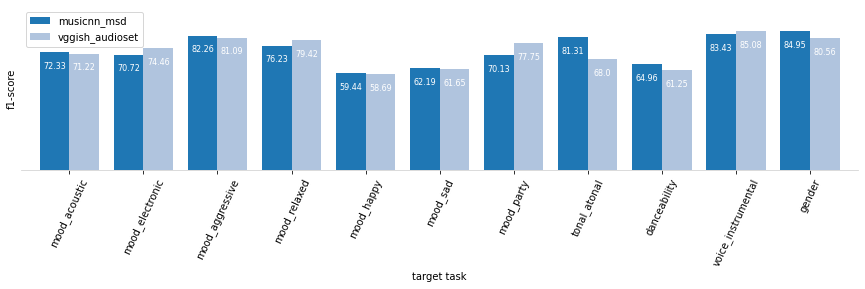

In [5]:
# computing and plotting scores

# classes of the models
classes = { "mood_acoustic" : ["acoustic", "not_acoustic"],
            "mood_electronic" : ["electronic", "not_electronic"],
            "mood_aggressive" : ["aggressive", "not_aggressive"],
            "mood_relaxed" : ["not_relaxed", "relaxed"],
            "mood_happy" : ["happy", "not_happy"],
            "mood_sad" : ["not_sad", "sad"],
            "mood_party" : ["not_party", "party"],
            "tonal_atonal" : ["tonal", "atonal"],
            "danceability" : ["danceable", "not_danceable"],
            "voice_instrumental" : ["instrumental", "voice"],
            "gender" : ["female", "male"] }

# target tasks by group
mood = ["mood_acoustic", "mood_electronic", "mood_aggressive", "mood_relaxed", "mood_happy", "mood_sad", "mood_party"]
miscellaneous = ["tonal_atonal", "danceability", "voice_instrumental", "gender"]
target_tasks = mood + miscellaneous # all target tasks

# initialize a list of f1-scores for each source task
f1_scores_musicnn = []
f1_scores_vggish = []
# fill the lists - a row per target task
for i, target_task in enumerate(target_tasks):
    if target_task != 'gender': 
        f1_scores_musicnn.append( f1_score(annotations[i, :], predictions_musicnn[i, :], average='weighted') )
        f1_scores_vggish.append( f1_score(annotations[i, :], predictions_vggish[i, :], average='weighted') )
    else: # gender annotations have 3 classes, so it requires different treatment
        idxs = np.squeeze( np.argwhere(annotations[i, :] != -1) ) # exclude data corresponding to the third annotated class
        f1_scores_musicnn.append( f1_score(annotations[i, :][idxs], predictions_musicnn[i, :][idxs], average='weighted') )
        f1_scores_vggish.append( f1_score(annotations[i, :][idxs], predictions_vggish[i, :][idxs], average='weighted') )

# plotting
df = pd.DataFrame(data = [f1_scores_musicnn, f1_scores_vggish], index = ["musicnn_msd", "vggish_audioset"], columns = target_tasks)
df.T.plot.bar(figsize = (15,3), color = ["tab:blue", "lightsteelblue"], width=0.80)
sns.set_style("white")
plt.ylim(0,1)
plt.xticks(rotation=65)
plt.yticks(ticks=[])
plt.xlabel('target task')
plt.ylabel('f1-score')
plt.tick_params( axis = 'x', bottom = True)
ax = plt.gca()
for bar in ax.patches: # put f1 scores on the bars
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()-0.1, str(round(bar.get_height()*100,2)), ha='center', color='w', fontsize=8)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('lightgrey')
plt.show()

To determine which source task provides the best overall results, the following cell computes two metrics:

* Weighted average of the weighted f1-scores of the target tasks. This average must be weighted since the support of the gender task is different from the rest, this is due to the fact that this task has three annotated classes, but the models only predict two of them, so the data corresponding to the annotated third class are discarded.
* Number of target tasks in which the source task performed best.

In [0]:
# comparing the performance of the source tasks

# target tasks by group
mood = ["mood_acoustic", "mood_electronic", "mood_aggressive", "mood_relaxed", "mood_happy", "mood_sad", "mood_party"]
miscellaneous = ["tonal_atonal", "danceability", "voice_instrumental", "gender"]
target_tasks = np.array( mood + miscellaneous ) # all target tasks

# weithed average of the weighted f1-scores
weights = [565] * 10 + [182] # 182 samples for the gender task
average_f1_scores_musicnn = np.average( f1_scores_musicnn, weights = weights )
average_f1_scores_vggish = np.average( f1_scores_vggish, weights = weights )
print("weighted average of weighted f1-scores:")
print("musicnn_msd\t", average_f1_scores_musicnn)
print("vggish_audioset\t", average_f1_scores_vggish)

# assign each target task to the source task that performed it best
musicnn_best = target_tasks[ np.squeeze(np.argwhere(np.array(f1_scores_musicnn) > np.array(f1_scores_vggish))) ]
vggish_best = target_tasks[ np.squeeze(np.argwhere(np.array(f1_scores_musicnn) < np.array(f1_scores_vggish))) ]
print("\nmusicnn_msd performed best in:\n", musicnn_best)
print("\nvggish_audioset performed best in:\n", vggish_best)

weighted average of weighted f1-scores:
musicnn	 0.7269308606754431
vggish	 0.7213220203842393

musicnn performed best in:
 ['mood_acoustic' 'mood_aggressive' 'mood_happy' 'mood_sad' 'tonal_atonal'
 'danceability' 'gender']

vggish performed best in:
 ['mood_electronic' 'mood_relaxed' 'mood_party' 'voice_instrumental']


For the source task identified as the best, the following cell plots confusion matrices for all 11 target tasks.

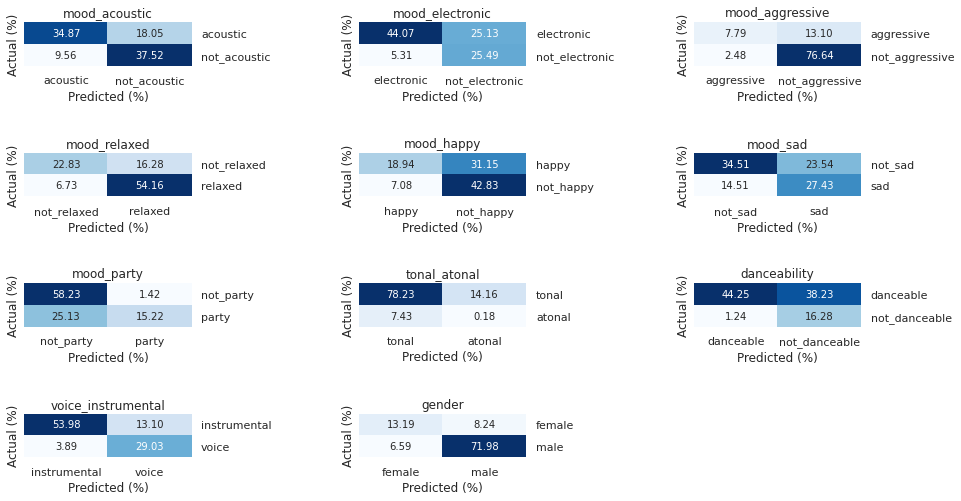

In [0]:
# computing confusion matrices for the source task with the best overall results

n_rows = 4
n_columns = 3
fig = plt.figure(1, figsize=(n_columns*5, n_rows*2))
fig.suptitle("musicnn_msd", fontsize=15)
plt.subplots_adjust(wspace = 1, hspace=2)

# compute a confusion matrix per target task
for i, target_task in enumerate(target_tasks):
    if target_task != "gender":
        confusion_matrix_df = pd.DataFrame(confusion_matrix(annotations[i, :], predictions_musicnn[i, :], normalize='all')*100, 
                                          columns = classes[target_task],
                                          index = classes[target_task])
    else: # gender annotations have 3 classes, so it requires different treatment
        idxs = np.squeeze( np.argwhere(annotations[i, :] != -1) ) # exclude data corresponding to the third annotated class
        confusion_matrix_df = pd.DataFrame(confusion_matrix(annotations[i, :][idxs], predictions_musicnn[i, :][idxs], normalize='all')*100,
                                          columns = classes[target_task],
                                          index = classes[target_task])
    confusion_matrix_df.index.name = 'Actual (%)'
    confusion_matrix_df.columns.name = 'Predicted (%)'
    
    # plotting
    plt.subplot(n_rows, n_columns, (i+1))
    plt.title(target_task)
    ax = plt.gca()
    ax.tick_params(axis = "y", labelright = 1, labelleft = 0, labelrotation = 0)
    sns.set(font_scale = 1)
    sns.heatmap(confusion_matrix_df, cmap = "Blues", annot_kws = {"size": 10}, annot = True, fmt =".2f", cbar = 0)

The next cell generates detailed reports for all 11 target tasks.

In [0]:
# generating detailed reports

for i, target_task in enumerate(target_tasks):
    print("-"*55)
    if target_task != 'gender':
        print("musicnn_msd - " + target_task)
        print( classification_report(annotations[i, :], predictions_musicnn[i, :], target_names = classes[target_task]) )

        print("vggish_audioset - " + target_task)
        print( classification_report(annotations[i, :], predictions_vggish[i, :], target_names = classes[target_task]) )
    else: # gender annotations have 3 classes, so it requires different treatment
        idxs = np.squeeze( np.argwhere(annotations[i, :] != -1) ) # exclude data corresponding to the third annotated class.
        print("musicnn_msd - " + target_task)
        print( classification_report(annotations[i, :][idxs], predictions_musicnn[i, :][idxs], target_names = classes[target_task]) )

        print("vggish_audioset - " + target_task)
        print( classification_report(annotations[i, :][idxs], predictions_vggish[i, :][idxs], target_names = classes[target_task]) )
    print("-"*55)

-------------------------------------------------------
musicnn - mood_acoustic
              precision    recall  f1-score   support

    acoustic       0.78      0.66      0.72       299
not_acoustic       0.68      0.80      0.73       266

    accuracy                           0.72       565
   macro avg       0.73      0.73      0.72       565
weighted avg       0.73      0.72      0.72       565

vggish - mood_acoustic
              precision    recall  f1-score   support

    acoustic       0.93      0.52      0.67       299
not_acoustic       0.64      0.95      0.77       266

    accuracy                           0.72       565
   macro avg       0.78      0.74      0.72       565
weighted avg       0.79      0.72      0.71       565

-------------------------------------------------------
-------------------------------------------------------
musicnn - mood_electronic
                precision    recall  f1-score   support

    electronic       0.89      0.64      0.74   